In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchtext.transforms as T
from torch import optim
from torch.utils.data import DataLoader
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.helpers.tokenizer import CharNgramTokenizer
from torchlake.common.helpers.transform import CustomVocabTransform
from torchlake.common.helpers.vocab import CharNgramVocab
from torchlake.common.schemas.nlp import NlpContext
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.common.utils.text import is_corpus_title, is_longer_text
from torchlake.language_model.constants.enum import LossType
from torchlake.text_classification.datasets.ag_news.constants import \
    CLASS_NAMES as AG_NEWS_CLASS_NAMES
from torchlake.text_classification.models import FastText
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import AG_NEWS

To utilize this notebook, you have to install `portalocker`, `spacy` first

# setting


In [2]:
DATASET_NAME = "AGNews"

In [3]:
artifact_path = Path('../../artifacts/fasttext')
artifact_dataset_path = artifact_path / DATASET_NAME
data_path = Path('../../data') / DATASET_NAME

In [15]:
NUM_CLASS = len(AG_NEWS_CLASS_NAMES)

In [4]:
CONTEXT = NlpContext(
    max_seq_len=512, # empirically based on n-grams
)

In [5]:
BATCH_SIZE = 1
CONTEXT_SIZE = 5

In [6]:
DEVICE = torch.device(CONTEXT.device)

In [8]:
BUCKET_SIZE = 10**5

In [7]:
tokenizer = get_tokenizer('basic_english')

In [9]:
ngram_vocab = CharNgramVocab(bucket_size=BUCKET_SIZE)
ngram_tokenizer = CharNgramTokenizer(tokenizer, ngram_vocab, [2])
ngram_tokenizer.activate_vocab()

In [10]:
def datapipe_factory(
    datapipe,
    minimum_length: int = 1,
    transform=None,
    indices_transform=None,
):
    datapipe = (
        datapipe.map(lambda pair: (pair[0], pair[1].strip()))  # label, text
        .map(lambda pair: (pair[0], pair[1].lower()))
        .filter(lambda pair: is_longer_text(pair[1], minimum_length))
        .filter(lambda pair: not is_corpus_title(pair[1]))
        .map(
            lambda pair: (pair[0], ngram_tokenizer(pair[1]))
        )  # label, (token, word_indices)
        # .map(lambda text: drop_keywords(text, stopwords.words('english')))
        # .batch(batch_size)
        # .map(lambda text: F.to_tensor(text, padding_value=padding_idx))
    )

    if transform:
        datapipe = datapipe.map(
            lambda pair: (
                (
                    transform(pair[1][0]), 
                    indices_transform(pair[1][1])
                ), 
                pair[0]-1,
            ) # (grams, indices), label
        )
    
    return datapipe

In [11]:
train_datapipe, test_datapipe = AG_NEWS(data_path.as_posix())

In [12]:
# create vocabulary
cloned_train_datapipe = datapipe_factory(train_datapipe, CONTEXT_SIZE)
for sentence in cloned_train_datapipe:
    pass

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\utils\common.py:141: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


In [13]:
# ngram_tokenizer.frozen_vocab()

In [14]:
vocab_size = len(ngram_vocab)

In [16]:
ngram_vocab.save_subword_vocab(artifact_dataset_path / "vocab.json")

In [17]:
text_transform = T.Sequential(
    CustomVocabTransform(ngram_vocab),
    # T.Truncate(CONTEXT.max_seq_len),
    # T.AddToken(token=CONTEXT.bos_idx, begin=True),
    # T.AddToken(token=CONTEXT.eos_idx, begin=False),
    T.ToTensor(),
    # T.PadTransform(CONTEXT.max_seq_len, CONTEXT.padding_idx),
)

In [18]:
indices_transform = T.Sequential(
    # T.Truncate(CONTEXT.max_seq_len),
    T.ToTensor(),
    # T.PadTransform(CONTEXT.max_seq_len, CONTEXT.padding_idx),
)

In [19]:
train_datapipe = datapipe_factory(
    train_datapipe,
    CONTEXT_SIZE,
    text_transform,
    indices_transform,
)

test_datapipe = datapipe_factory(
    test_datapipe,
    CONTEXT_SIZE,
    text_transform,
    indices_transform,
)

In [20]:
count = 0
for (grams, indices), label in train_datapipe:
    print(grams.shape)
    print(indices.shape)
    print(label)
    if count > 50:
        break
    count+=1

torch.Size([95])
torch.Size([95])
2
torch.Size([189])
torch.Size([189])
2
torch.Size([157])
torch.Size([157])
2
torch.Size([181])
torch.Size([181])
2
torch.Size([155])
torch.Size([155])
2
torch.Size([152])
torch.Size([152])
2
torch.Size([130])
torch.Size([130])
2
torch.Size([165])
torch.Size([165])
2
torch.Size([255])
torch.Size([255])
2
torch.Size([92])
torch.Size([92])
2
torch.Size([150])
torch.Size([150])
2
torch.Size([168])
torch.Size([168])
2
torch.Size([141])
torch.Size([141])
2
torch.Size([170])
torch.Size([170])
2
torch.Size([163])
torch.Size([163])
2
torch.Size([90])
torch.Size([90])
2
torch.Size([99])
torch.Size([99])
2
torch.Size([163])
torch.Size([163])
2
torch.Size([96])
torch.Size([96])
2
torch.Size([98])
torch.Size([98])
2
torch.Size([118])
torch.Size([118])
2
torch.Size([108])
torch.Size([108])
2
torch.Size([88])
torch.Size([88])
2
torch.Size([98])
torch.Size([98])
2
torch.Size([87])
torch.Size([87])
2
torch.Size([98])
torch.Size([98])
2
torch.Size([96])
torch.Size([96]

In [21]:
NUM_WORKERS = get_num_workers()

In [22]:
train_dataloader = DataLoader(
    train_datapipe,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=NUM_WORKERS,
)

test_dataloader = DataLoader(
    test_datapipe,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=NUM_WORKERS,
)

In [23]:
count = 0
for (grams, indices), label in train_dataloader:
    print(grams.shape)
    print(indices.shape)
    print(label.shape)
    if count > 50:
        break
    count+=1

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\iter\combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


torch.Size([1, 95])
torch.Size([1, 95])
torch.Size([1])
torch.Size([1, 189])
torch.Size([1, 189])
torch.Size([1])
torch.Size([1, 157])
torch.Size([1, 157])
torch.Size([1])
torch.Size([1, 181])
torch.Size([1, 181])
torch.Size([1])
torch.Size([1, 155])
torch.Size([1, 155])
torch.Size([1])
torch.Size([1, 152])
torch.Size([1, 152])
torch.Size([1])
torch.Size([1, 130])
torch.Size([1, 130])
torch.Size([1])
torch.Size([1, 165])
torch.Size([1, 165])
torch.Size([1])
torch.Size([1, 255])
torch.Size([1, 255])
torch.Size([1])
torch.Size([1, 92])
torch.Size([1, 92])
torch.Size([1])
torch.Size([1, 150])
torch.Size([1, 150])
torch.Size([1])
torch.Size([1, 168])
torch.Size([1, 168])
torch.Size([1])
torch.Size([1, 141])
torch.Size([1, 141])
torch.Size([1])
torch.Size([1, 170])
torch.Size([1, 170])
torch.Size([1])
torch.Size([1, 163])
torch.Size([1, 163])
torch.Size([1])
torch.Size([1, 90])
torch.Size([1, 90])
torch.Size([1])
torch.Size([1, 99])
torch.Size([1, 99])
torch.Size([1])
torch.Size([1, 163])
t

# training


In [24]:
EMBED_DIM = 300

In [27]:
EPOCHES = 10
ACC_ITERS = 32 / BATCH_SIZE
LR = 1e-3

In [28]:
trainer = ClassificationTrainer(EPOCHES, DEVICE, ACC_ITERS, feature_last=True)

In [29]:
model = FastText(
    ngram_vocab.bucket_size,
    EMBED_DIM,
    NUM_CLASS,
    loss_type=LossType.CE,
    context=CONTEXT,
).to(DEVICE)

In [28]:
loss = trainer.get_criterion(NUM_CLASS)
optimizer = optim.Adam(model.parameters(), lr=LR)

In [29]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
FastText                                 --
├─Embedding: 1-1                         30,000,000
├─Linear: 1-2                            1,204
Total params: 30,001,204
Trainable params: 30,001,204
Non-trainable params: 0

In [ ]:
training_loss = trainer.run(train_dataloader, model, optimizer, loss)

In [ ]:
plt.plot(training_loss)

# Inference

In [32]:
evaluator = ClassificationEvaluator(NUM_CLASS, DEVICE, feature_dim=-1)

In [33]:
confusion_matrix = evaluator.run(iter(test_dataloader), model)

0it [00:00, ?it/s]

7599it [00:18, 400.21it/s]

[[1532  160  112   96]
 [  59 1771   33   37]
 [ 134  114 1411  240]
 [  95  138  200 1467]]


In [34]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(AG_NEWS_CLASS_NAMES, per_class_acc)

world     : 0.8063157894736842
sports    : 0.9321052631578948
business  : 0.7430226434965771
science   : 0.7721052631578947


In [35]:
per_class_acc.mean()

0.8133872398215127

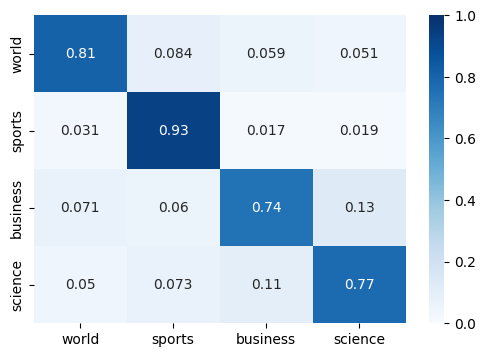

In [37]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    AG_NEWS_CLASS_NAMES,
    "Blues",
    annot=True,
    figsize=(6, 4),
)

# File


In [30]:
model_path = artifact_path / "fasttext.pth"

In [34]:
torch.save(model.state_dict(), model_path)

In [35]:
get_file_size(model_path)

'114.45MB'

In [31]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>